In [1]:
import numpy as np
import pandas as pd

import scanpy.api as sc
sc.settings.verbosity = 3                # verbosity = 3: errors, warnings, info, hints
sc.settings.set_figure_params(dpi=70)    # dots (pixels) per inch determine size of inline figures
sc.logging.print_version_and_date()

from matplotlib import pyplot as plt
import matplotlib.colors as mcol
cm1 = mcol.LinearSegmentedColormap.from_list("BuRd",["b","r"])

/home/jpoles1/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Running Scanpy version 0.2.8 on 2017-10-26 14:01.


## Loading Data

In [2]:
data_folder = "data/regression/"
filename_data = data_folder+"matrix.mtx"
filename_genes = data_folder+"genes.tsv"
filename_barcodes = data_folder+"barcodes.tsv"
adata = sc.read(filename_data, cache=True).transpose()
adata.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
adata.smp_names = np.genfromtxt(filename_barcodes, dtype=str)

reading file data/regression/matrix.mtx
... did not find row_names or col_names
... writing an h5 cache file to speedup reading next time
writing ./write/data/regression/matrix.h5


## Preprocessing

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [4]:
mito_genes = np.array([name for name in adata.var_names if name.startswith('mt-')])
# for each cell compute fraction of counts in mito genes vs. all genes
adata.smp['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as sample annotation to adata
adata.smp['n_counts'] = np.sum(adata.X, axis=1).A1

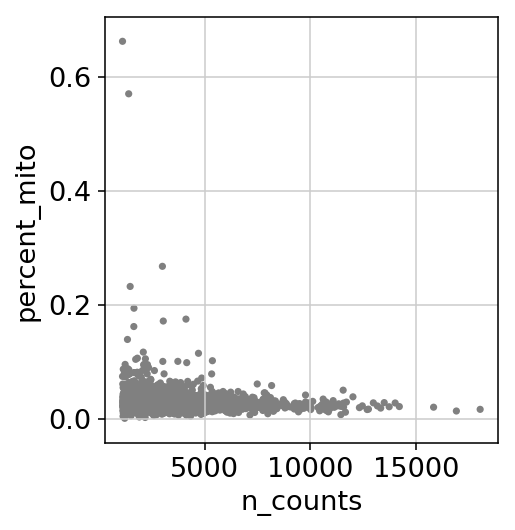

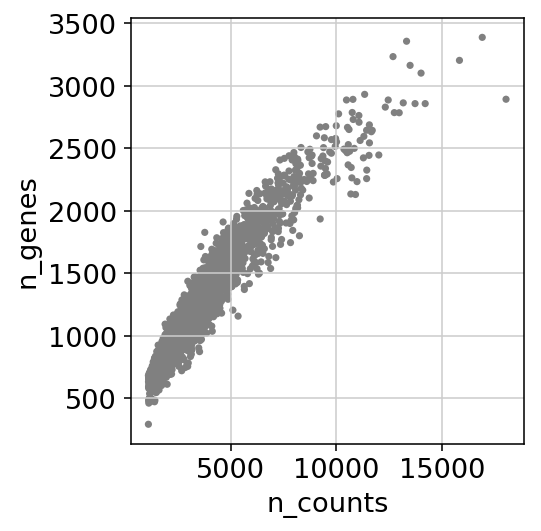

In [5]:
axs = sc.pl.scatter(adata, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [6]:
print(adata.n_smps)
adata[adata.smp['n_genes'] < 2500, :]
adata = adata[adata.smp['percent_mito'] < 0.05, :]
print(adata.n_smps)

2198
2055


In [7]:
sc.write(data_folder+'pbmc3k_filtered_raw_log', sc.pp.log1p(adata, copy=True))

writing ./write/data/regression/pbmc3k_filtered_raw_log.h5


normalizing by total count per cell
    finished (0:00:00.052) normalized adata.X and added
    "n_counts", counts per cell before normalization (adata.smp)
filter highly varying genes by dispersion and mean (0:00:00.254)
--> set `n_top_genes` to simply select top-scoring genes instead


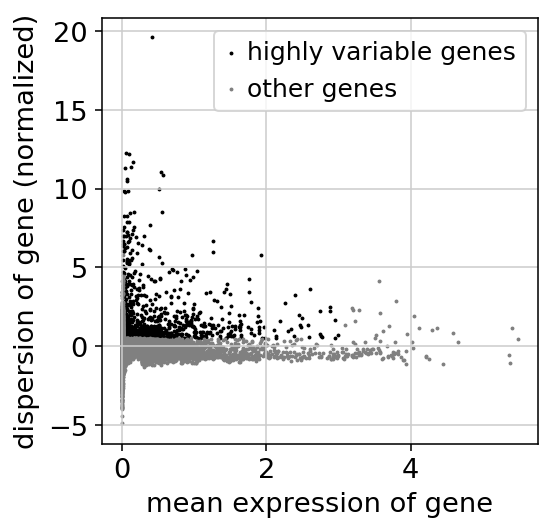

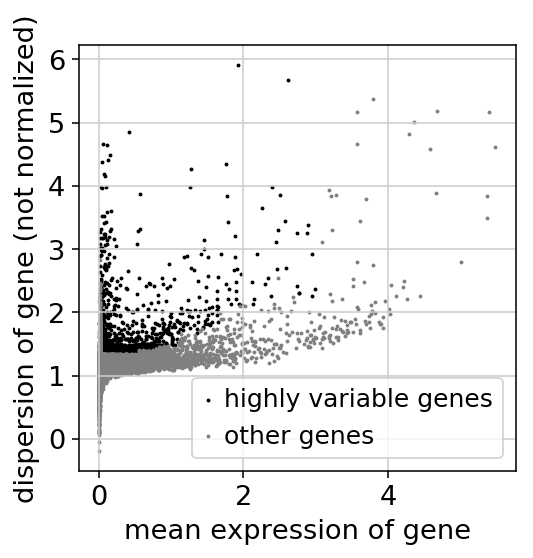

In [8]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [9]:
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)

In [10]:
adata_corrected = sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], copy=True)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [11]:
sc.pp.scale(adata_corrected, max_value=10)

In [12]:
sc.write(data_folder+'pbmc3k_corrected', adata_corrected)

writing ./write/data/regression/pbmc3k_corrected.h5


## Dimensionality Reduction

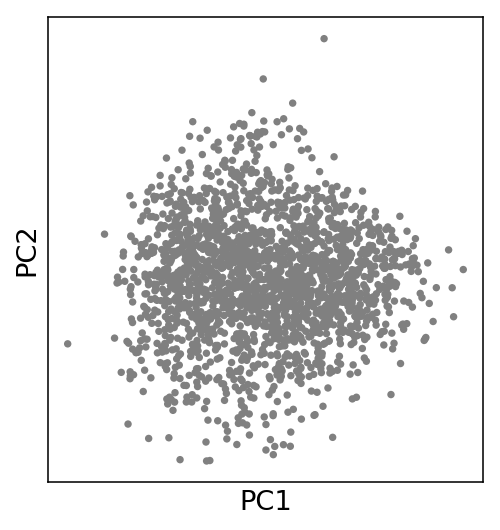

In [13]:
sc.tl.pca(adata_corrected)
ax = sc.pl.pca_scatter(adata_corrected, right_margin=0.2)

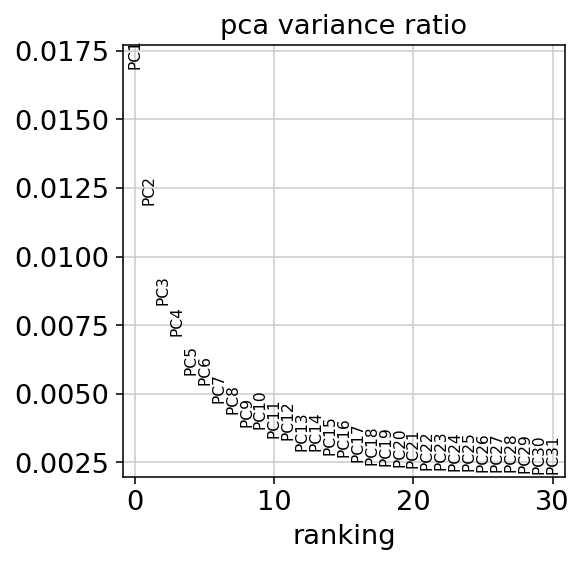

In [14]:
sc.pl.pca_variance_ratio(adata_corrected, log=0)

In [15]:
adata_corrected = sc.read(data_folder+'pbmc3k_corrected')

reading file ./write/data/regression/pbmc3k_corrected.h5


In [16]:
sc.tl.tsne(adata_corrected, n_pcs=15)

computing tSNE
    preprocess using PCA with 15 PCs
--> avoid this by setting n_pcs = 0
    using 15 principal components
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:06.808) and added
    "X_tsne", tSNE coordinates (adata.smp)


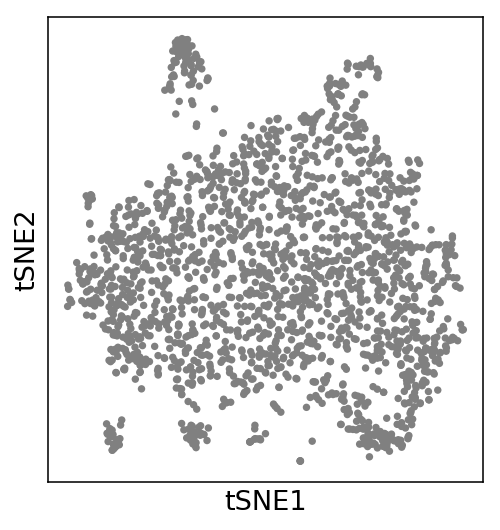

In [17]:
ax = sc.pl.tsne(adata_corrected)

## Clustering

In [18]:
sc.tl.louvain(adata_corrected, flavor="igraph", recompute_graph=True, n_pcs=15)

running Louvain clustering
    using "X_pca" for building graph
    computing data graph with n_neighbors = 30 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9388936758  0.9305095077  0.9101098776  0.880749166
      0.8479124308  0.8344816566  0.8214908838  0.8080903292  0.7873901725
      0.7761721611  0.7519258857  0.7359935045  0.717864573   0.7024840117]
    finished (0:00:01.483) and found 10 clusters, added
    "louvain_groups", the cluster labels (adata.smp)
    "louvain_groups_order", the unique cluster labels (adata.add)


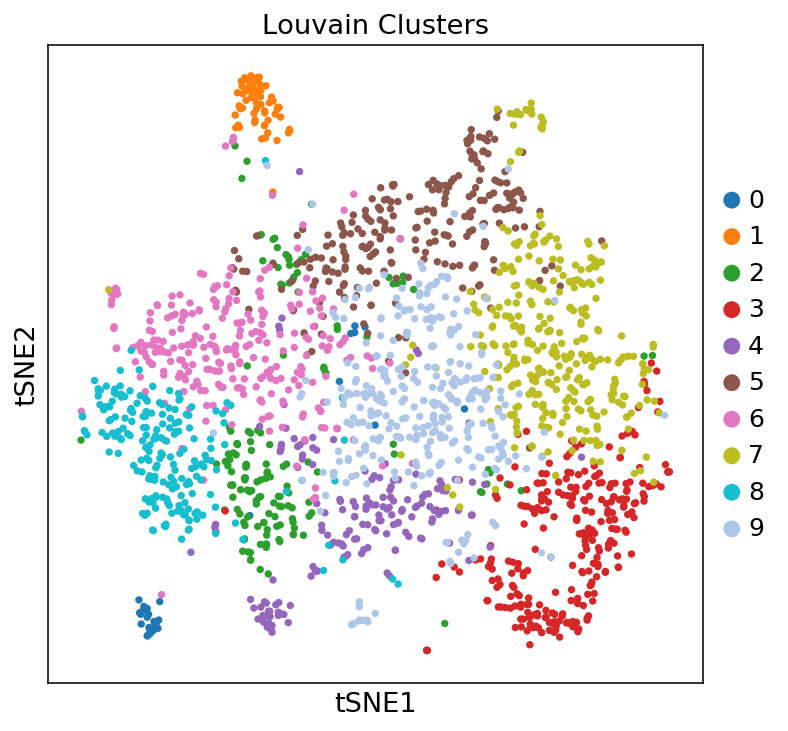

In [19]:
plt.figure(figsize=[6,6])
ax = plt.subplot(111)
sc.pl.tsne(adata_corrected, color='louvain_groups', title="Louvain Clusters", ax=ax, show=0)
plt.show()

In [20]:
sc.write(data_folder+'pbmc3k_corrected', adata_corrected)

writing ./write/data/regression/pbmc3k_corrected.h5


reading file ./write/data/regression/pbmc3k_corrected.h5
reading file ./write/data/regression/pbmc3k_filtered_raw_log.h5
find differentially expressed genes
... consider "louvain_groups": ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9'] with sample numbers [ 33  61 153 273 166 248 270 330 202 319]
    finished (0:00:01.273) and added
    "rank_genes_groups_gene_names", np.recarray to be indexed by the `groups` (adata.add)
    "rank_genes_groups_gene_zscores", the scores (adata.add)
    "rank_genes_...", distributions of top-ranked genes (adata.smp)


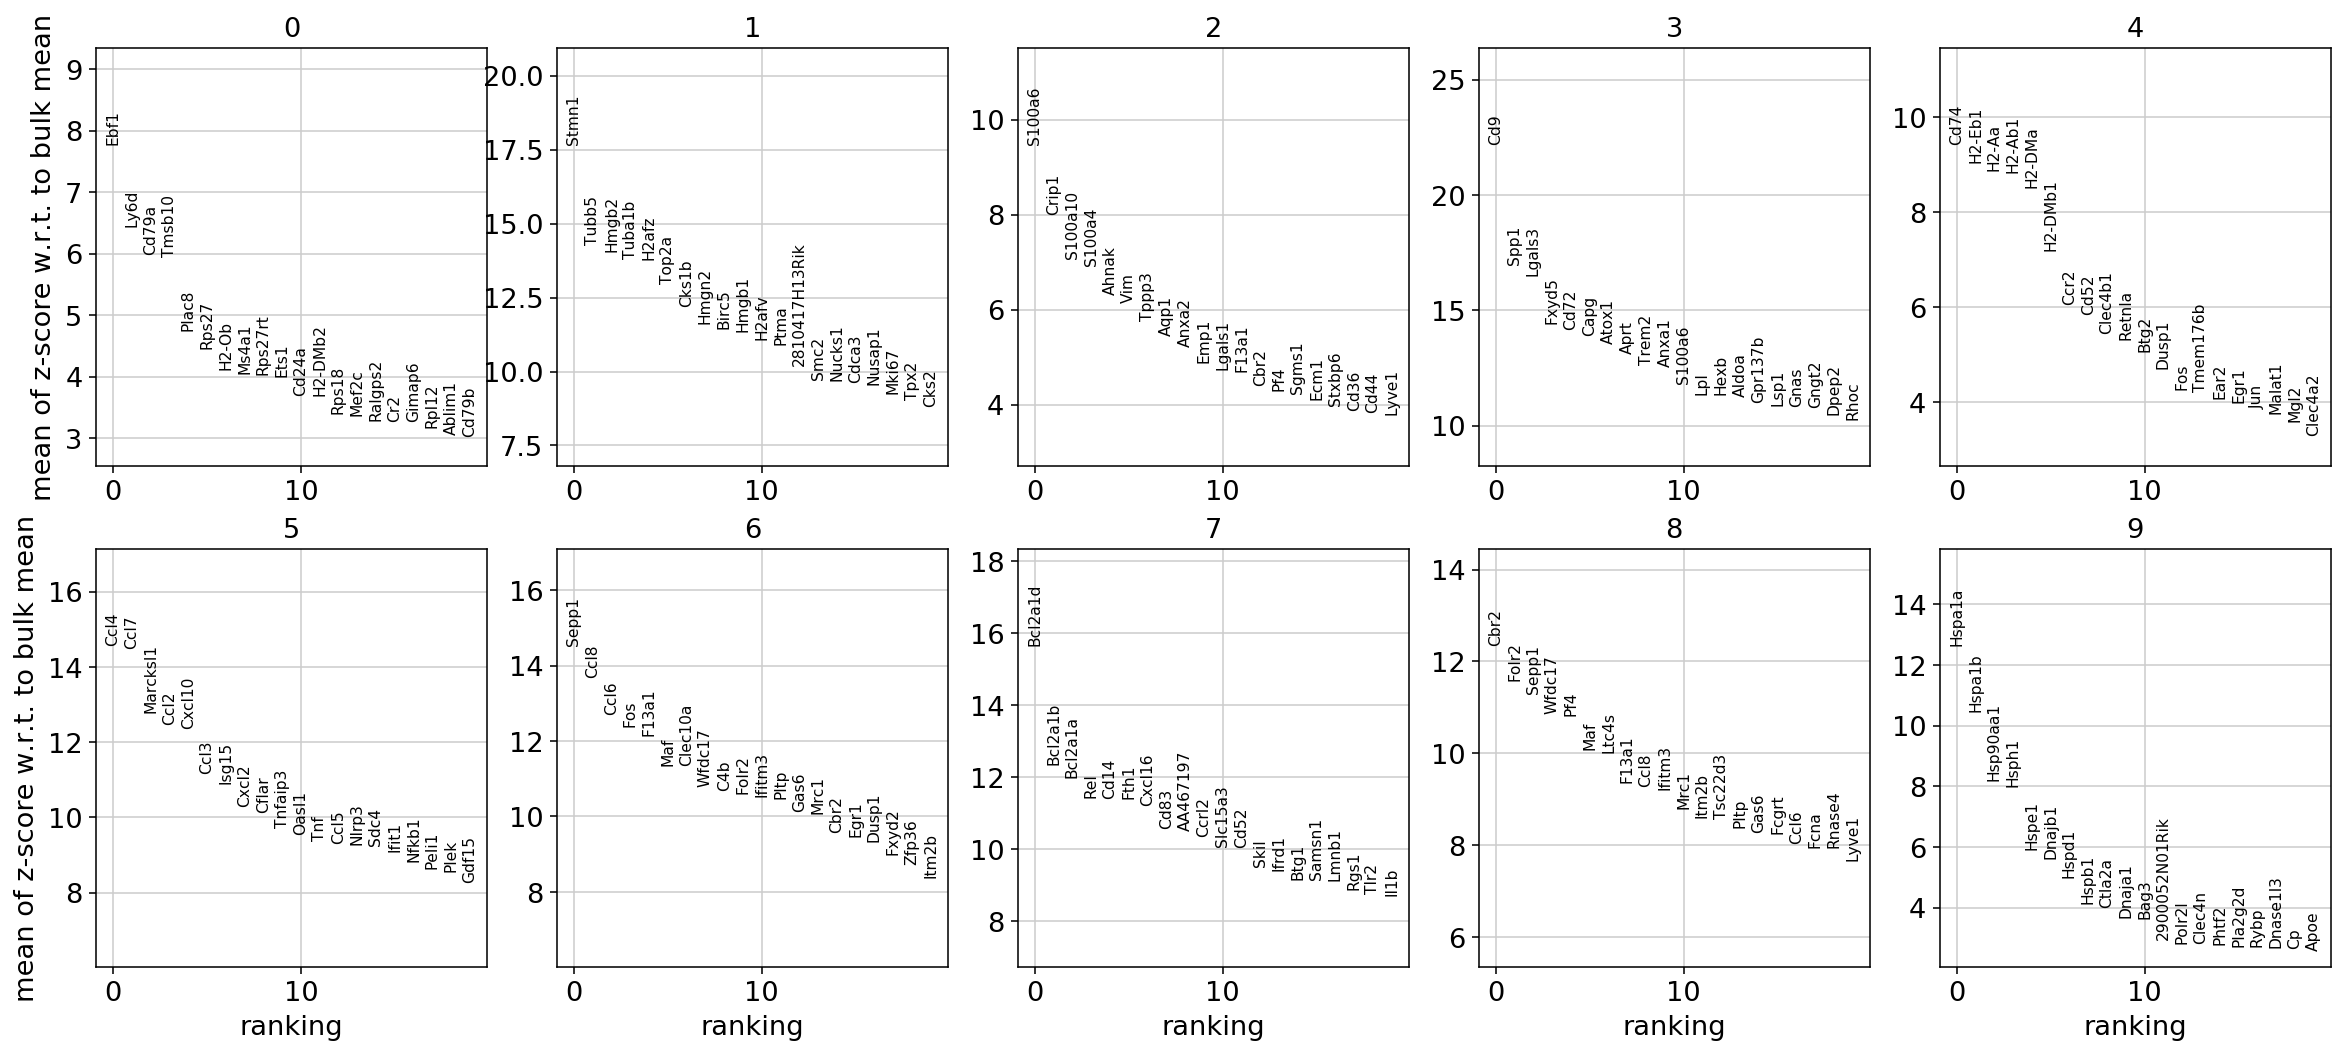

In [21]:
adata_corrected = sc.read(data_folder+'pbmc3k_corrected')
adata_raw = sc.read(data_folder+'pbmc3k_filtered_raw_log')
adata_raw.smp['louvain_groups'] = adata_corrected.smp['louvain_groups']
adata_raw.smp["X_tsne"] = adata_corrected.smp["X_tsne"]
sc.tl.rank_genes_groups(adata_raw, 'louvain_groups')
sc.pl.rank_genes_groups(adata_raw, n_genes=20)

In [22]:
diff_genes = sc.tl.rank_genes_groups(adata_raw, 'louvain_groups', copy=1)
diff_genes = pd.DataFrame(diff_genes.add["rank_genes_groups_gene_names"])

find differentially expressed genes
... consider "louvain_groups": ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9'] with sample numbers [ 33  61 153 273 166 248 270 330 202 319]
    finished (0:00:01.239) and added
    "rank_genes_groups_gene_names", np.recarray to be indexed by the `groups` (adata.add)
    "rank_genes_groups_gene_zscores", the scores (adata.add)
    "rank_genes_...", distributions of top-ranked genes (adata.smp)


In [23]:
def top_clust_genes(clust_num, top_n=5):
    print("Plotting Heatmaps for top "+str(top_n)+" genes in cluster #"+str(clust_num))
    for gene_name in np.array(diff_genes.iloc[:top_n, clust_num]):
        sc.pl.tsne(adata_raw, color=gene_name, title=gene_name+" Expression", color_map=cm1)

Plotting Heatmaps for top 10 genes in cluster #0


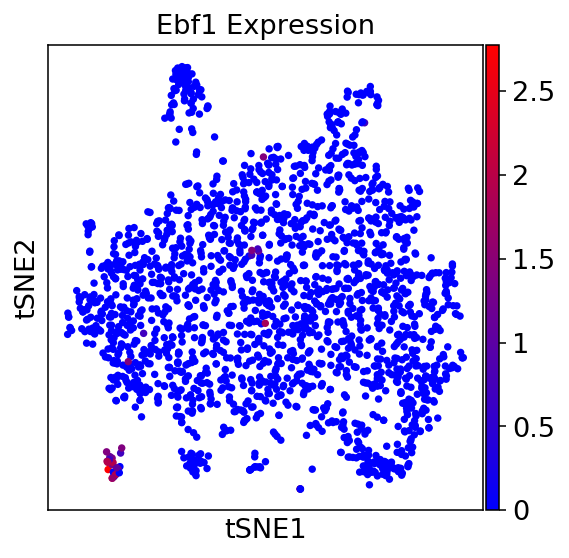

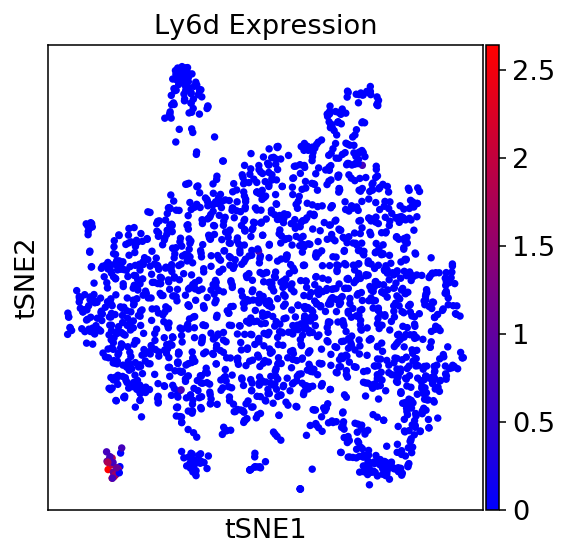

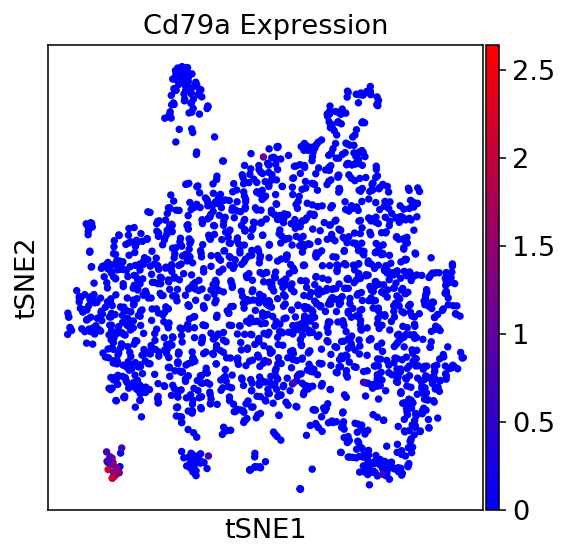

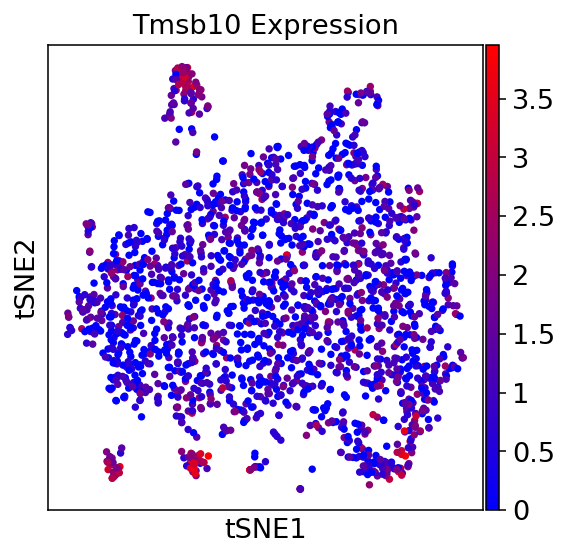

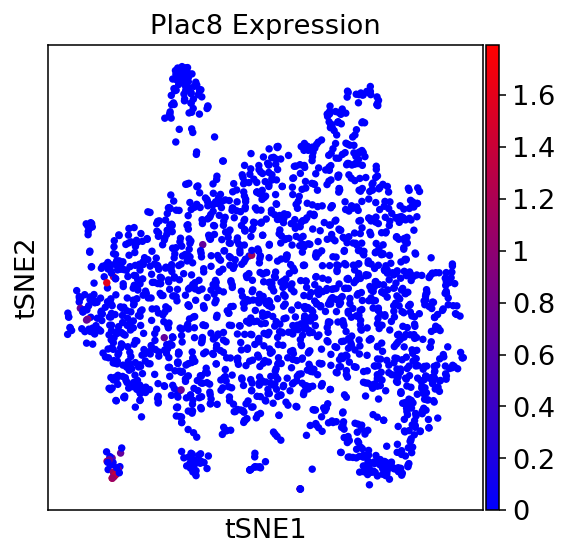

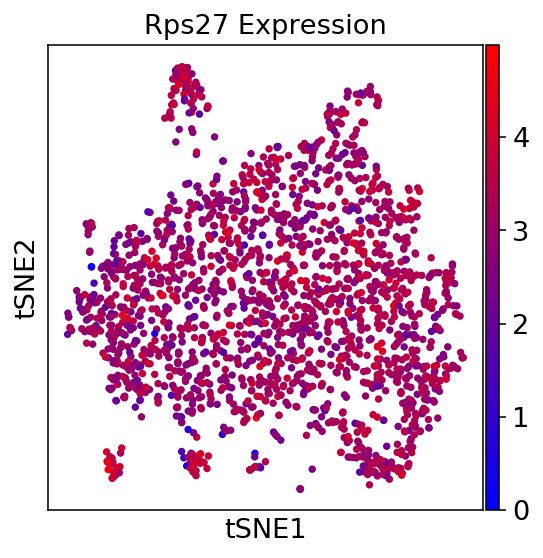

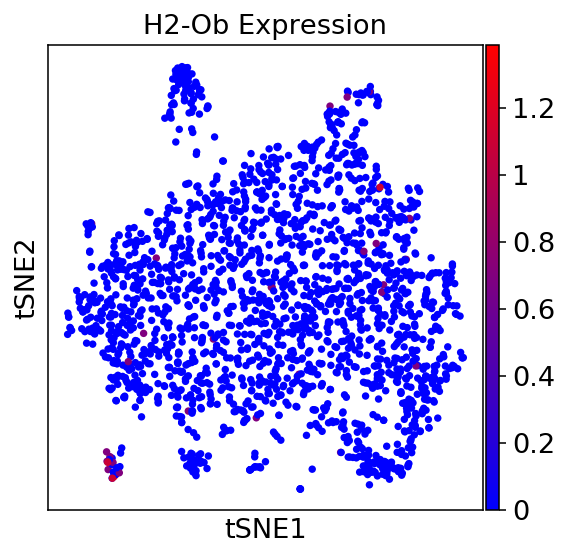

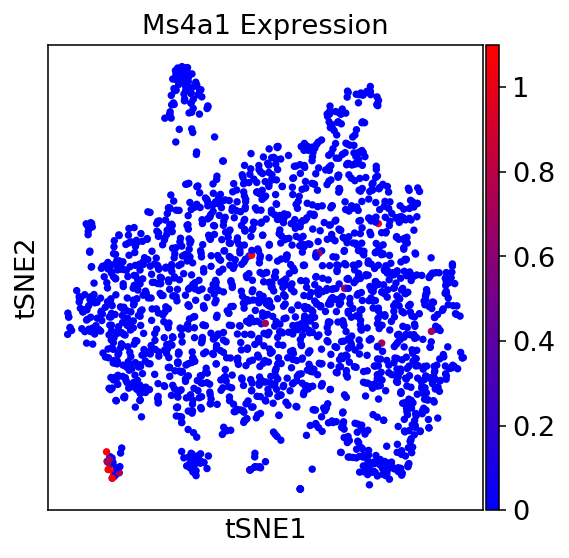

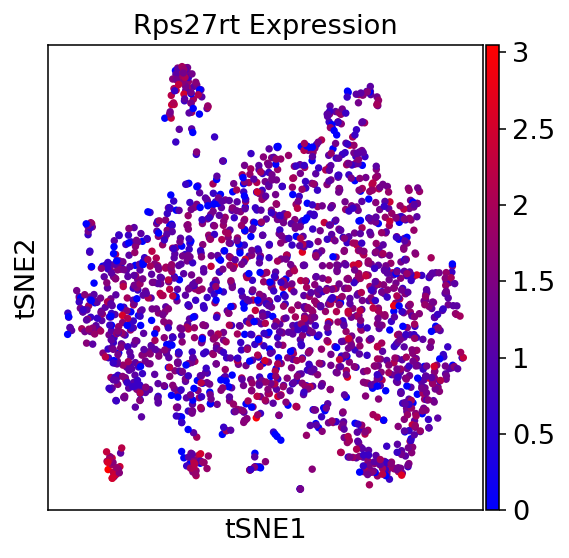

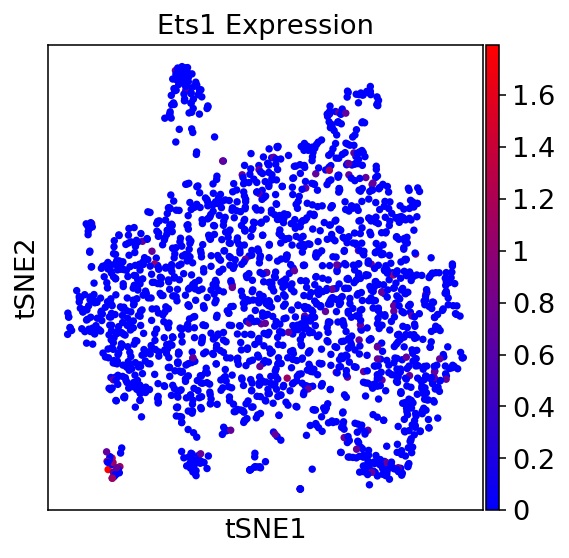

Plotting Heatmaps for top 10 genes in cluster #7


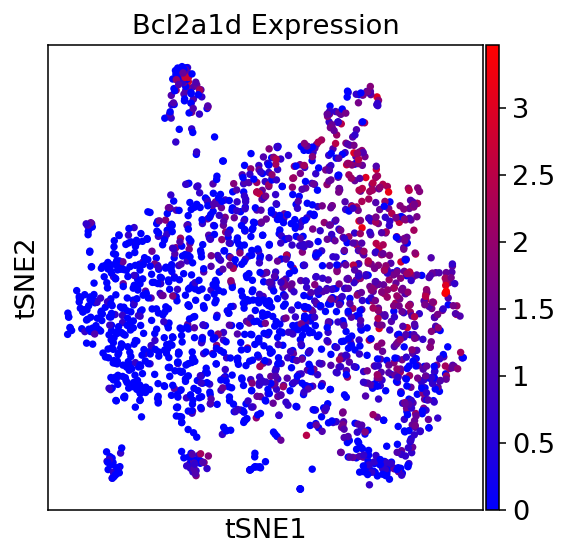

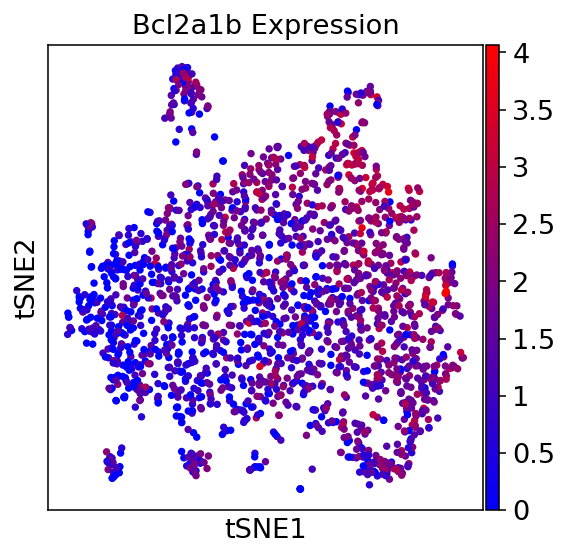

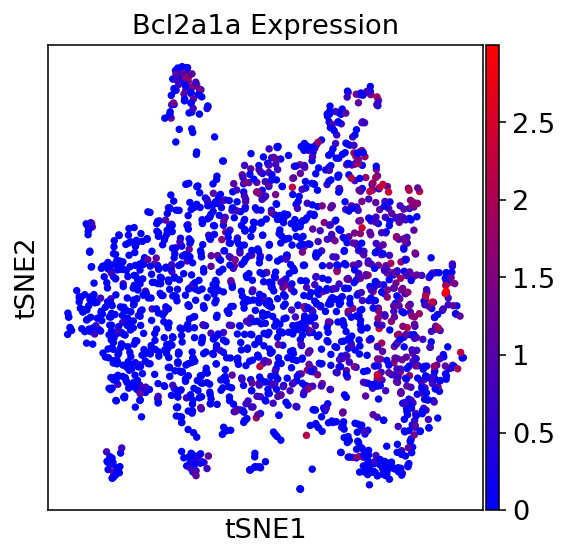

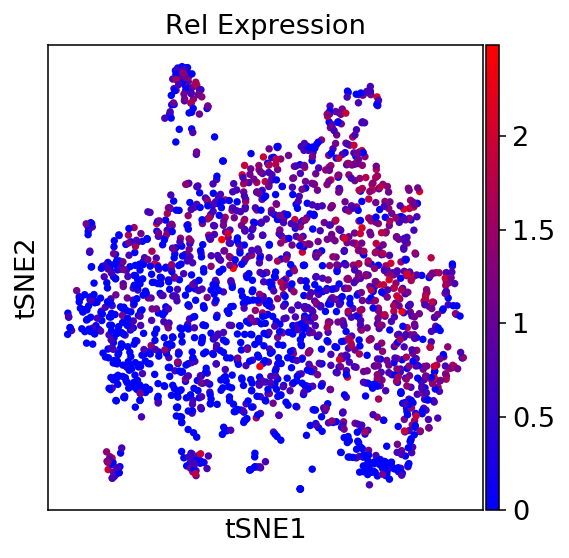

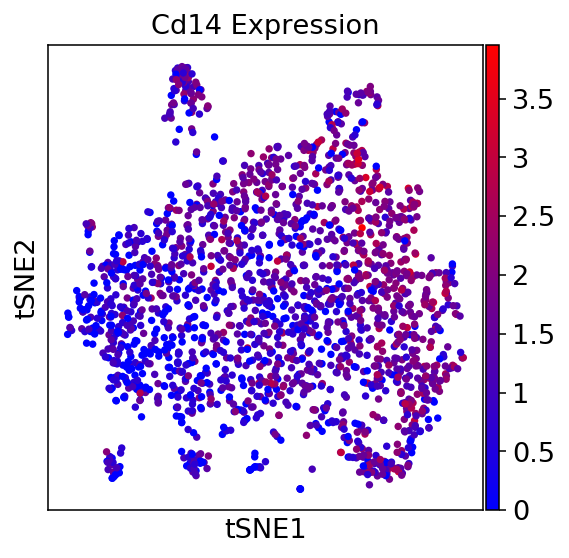

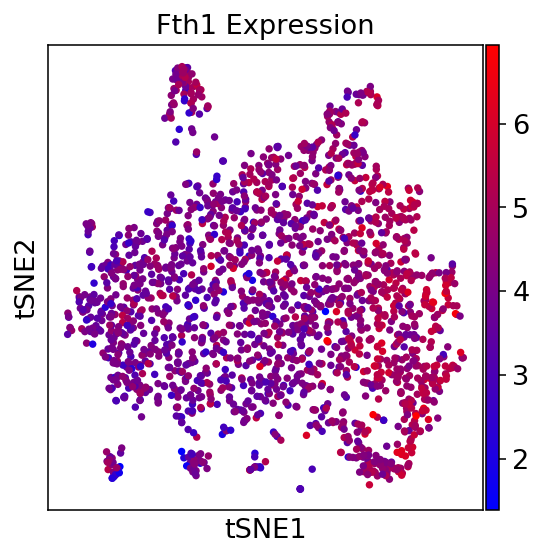

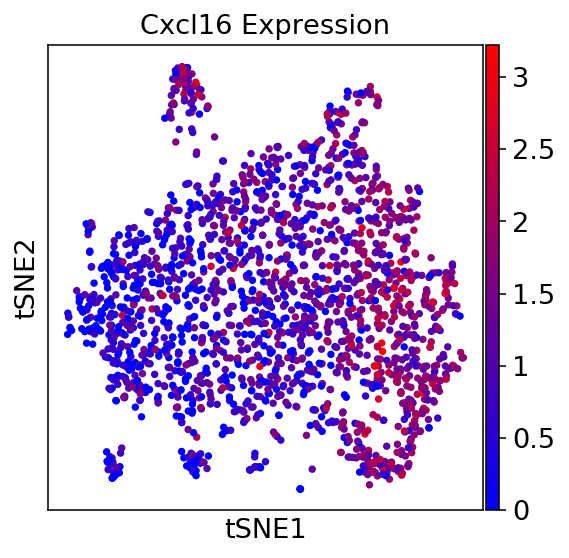

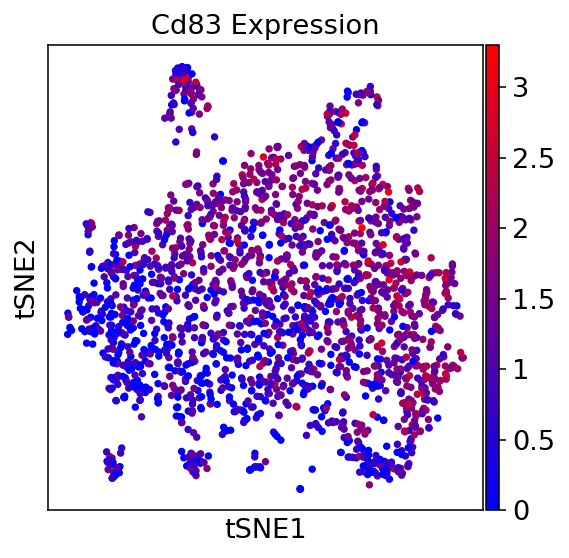

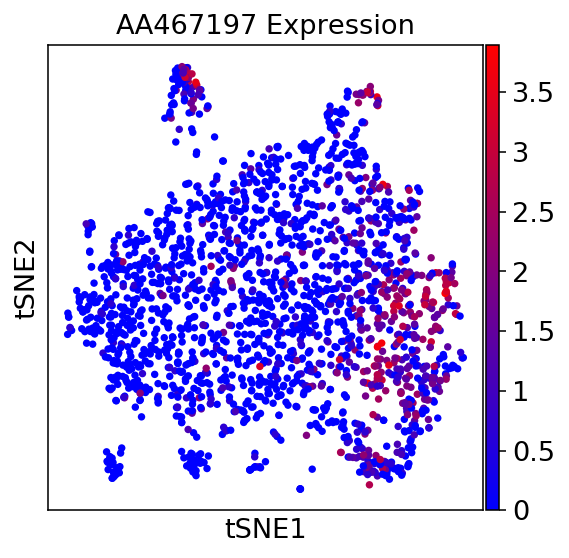

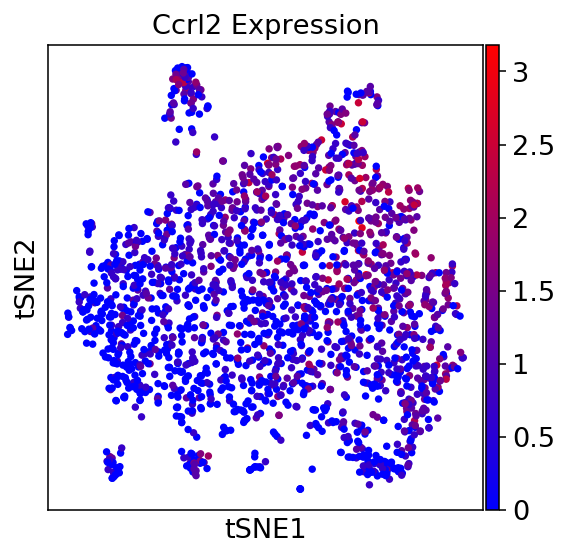

In [24]:
top_clust_genes(0, 10)
top_clust_genes(7, 10)

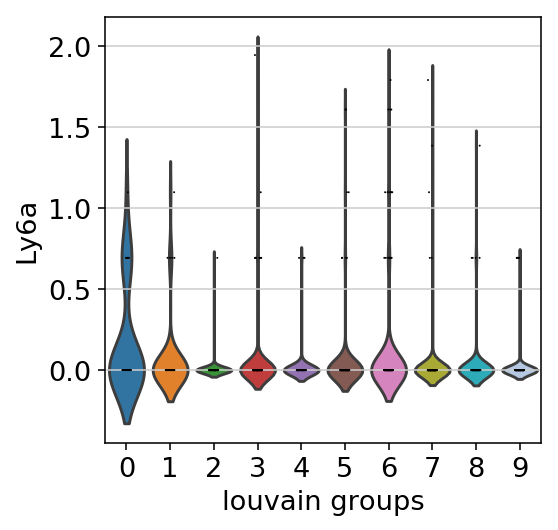

In [25]:
ax = sc.pl.violin(adata_raw, 'Ly6a', group_by='louvain_groups')

Plotting Heatmaps for top 5 genes in cluster #6


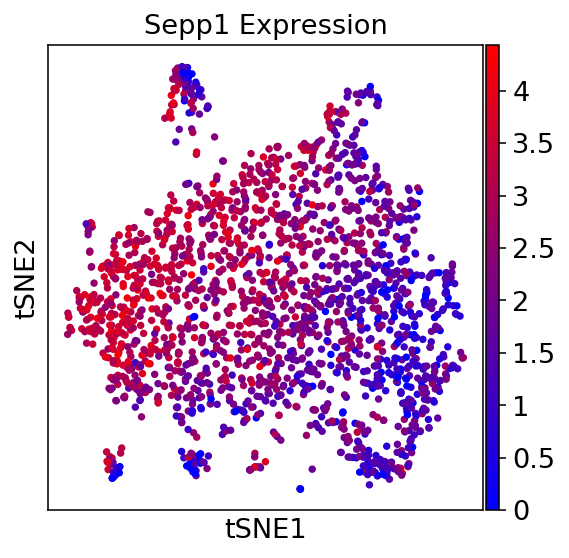

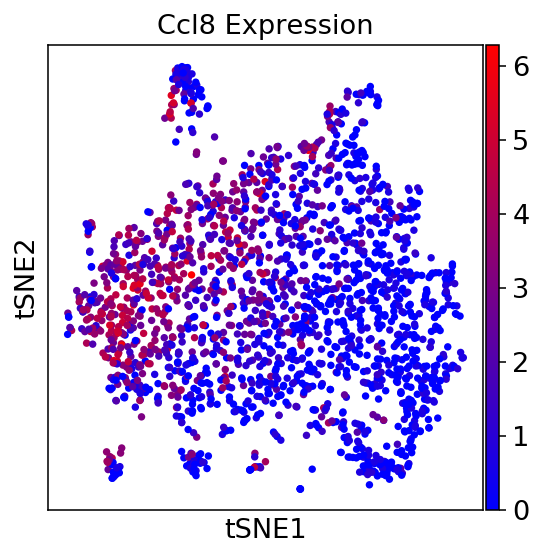

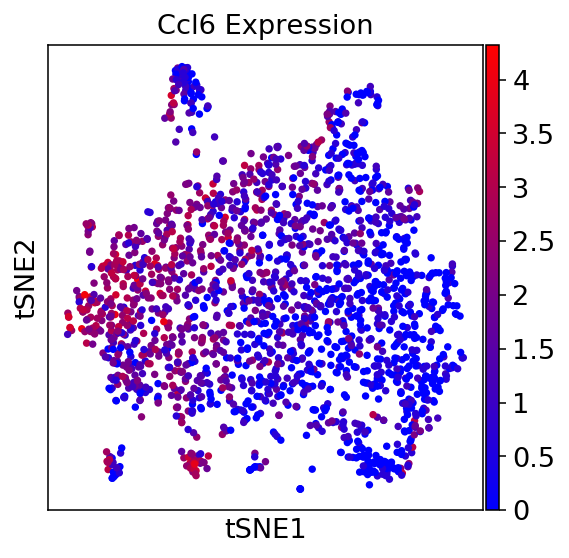

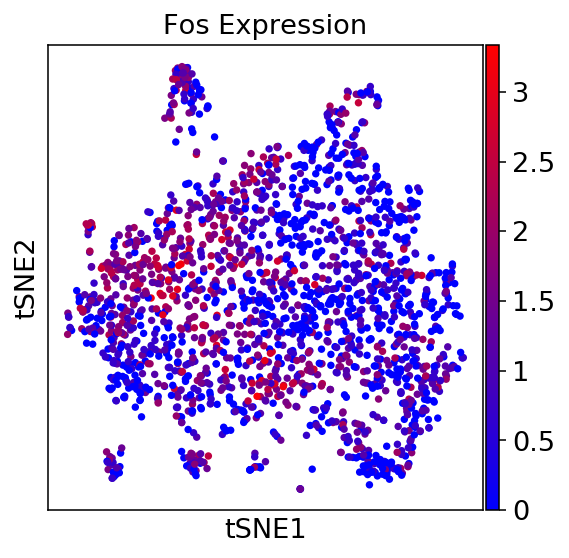

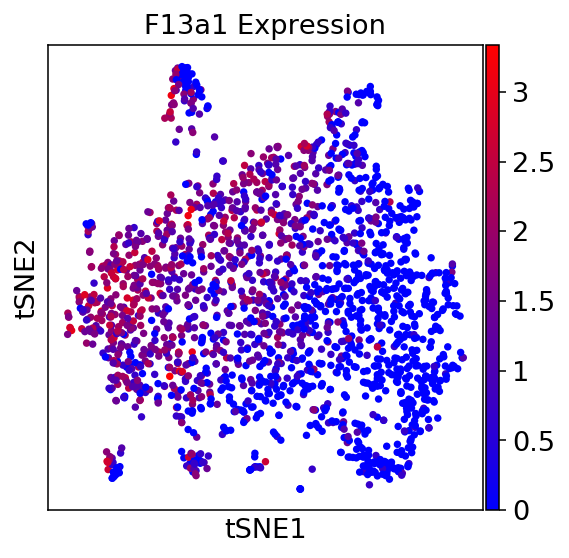

Plotting Heatmaps for top 5 genes in cluster #4


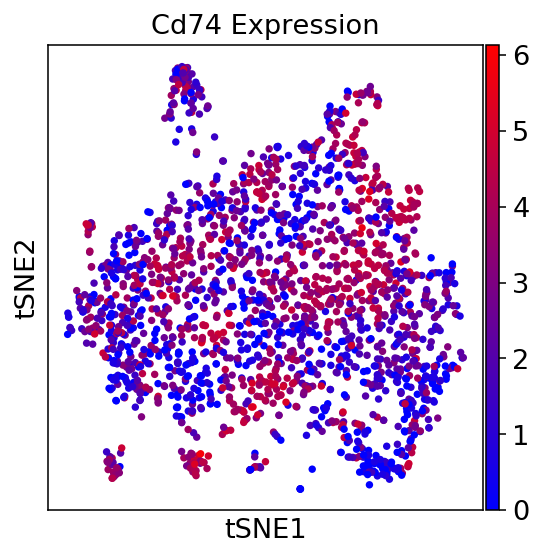

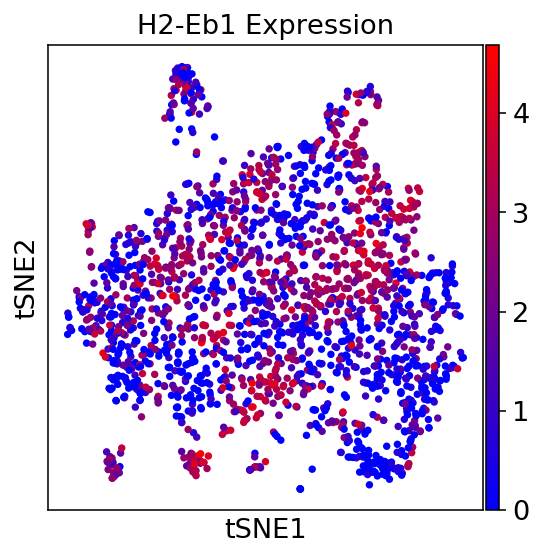

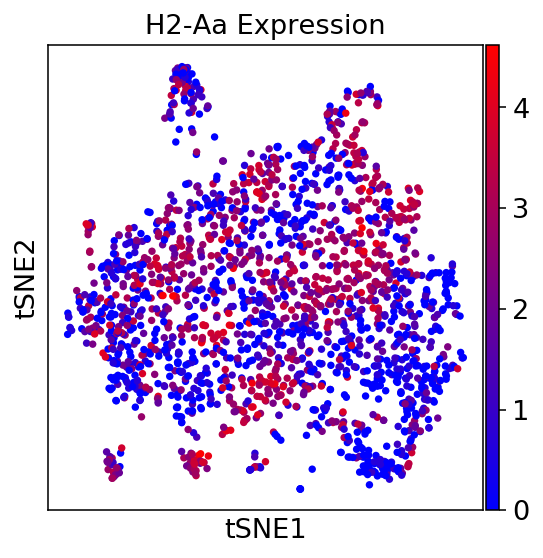

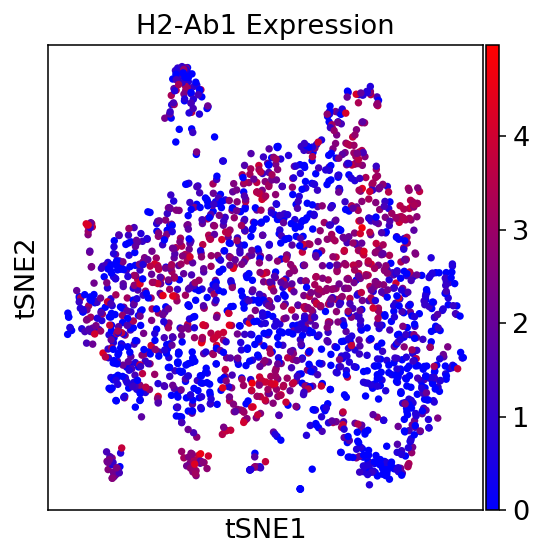

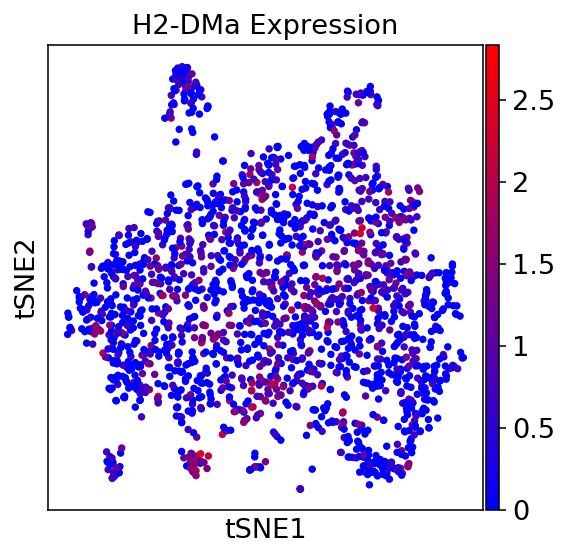

In [26]:
top_clust_genes(6)
top_clust_genes(4)